Multi-Month Risk Monitoring & Trend Analysis

This notebook analyses risk engine outputs across multiple months.

Inputs:

Final risk-scored transaction files (monthly)

Objectives:

Detect decision drift

Monitor ML risk stability

Track trust evolution

Compare new vs existing customer risk

This mirrors how payment risk systems are monitored in production.

In [1]:
import pandas as pd
import numpy as np
import os

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)


In [2]:
# ============================================================
# LOAD MULTI-MONTH FINAL OUTPUTS
# ============================================================

BASE_PATH = r"\CROSS_BORDER_FRAUD\OUTPUTS\RISK_SCORE_TXNS"

MONTHS = ["2025_01", "2025_02", "2025_03"]

dfs = []

for month in MONTHS:
    path = os.path.join(BASE_PATH, f"risk_scored_transactions_{month}.csv")
    temp = pd.read_csv(path, parse_dates=["transaction_timestamp"])
    temp["month"] = month
    dfs.append(temp)

multi_df = pd.concat(dfs, ignore_index=True)

print("Combined dataset shape:", multi_df.shape)
display(multi_df.head())


Combined dataset shape: (318433, 14)


,transaction_id,customer_id,transaction_timestamp,transaction_amount,source_country,destination_country,is_new_device,is_new_customer,trust_score,rule_trigger_count,ml_risk_score,decision,reason_codes_str,month
0,TXN_3234489_CUST_000001,CUST_000001,2025-01-29 14:00:00,379.40,IN,US,0,0,54,0,7.708996e-15,ALLOW,No significant risk signals,2025_01
1,TXN_5472471_CUST_000001,CUST_000001,2025-01-19 22:00:00,76.14,IN,US,0,0,54,0,8.312215e-15,ALLOW,No significant risk signals,2025_01
2,TXN_5521373_CUST_000001,CUST_000001,2025-01-03 21:00:00,75.39,IN,AE,0,0,54,0,7.964325e-15,ALLOW,No significant risk signals,2025_01
3,TXN_6664789_CUST_000001,CUST_000001,2025-01-06 01:00:00,131.82,IN,UK,0,0,54,0,1.504154e-15,ALLOW,No significant risk signals,2025_01
4,TXN_5721339_CUST_000002,CUST_000002,2025-01-12 16:00:00,286.15,IN,UK,0,0,32,0,1.584094e-08,ALLOW,No significant risk signals,2025_01


M1: Decision Drift Over Time

This chart shows how transaction decisions change month over month.

We monitor:

Percentage of ALLOW, REVIEW, BLOCK decisions

Stability of the risk engine

Any unintended tightening or loosening of controls

A stable system should show:

Minor natural variation

No sudden spikes in BLOCK or REVIEW

In [3]:
# ============================================================
# M1: DECISION DRIFT CALCULATION
# ============================================================

# Calculate decision proportions per month
decision_counts = (
    multi_df
    .groupby(["month", "decision"])
    .size()
    .reset_index(name="count")
)

decision_counts["total"] = decision_counts.groupby("month")["count"].transform("sum")
decision_counts["proportion"] = decision_counts["count"] / decision_counts["total"]

decision_pivot = decision_counts.pivot(
    index="month",
    columns="decision",
    values="proportion"
).fillna(0)

decision_pivot


decision,ALLOW,BLOCK,REVIEW
month,,,
2025_01,0.952647,0.039980,0.007374
2025_02,0.954648,0.038467,0.006885
2025_03,0.955296,0.037330,0.007374


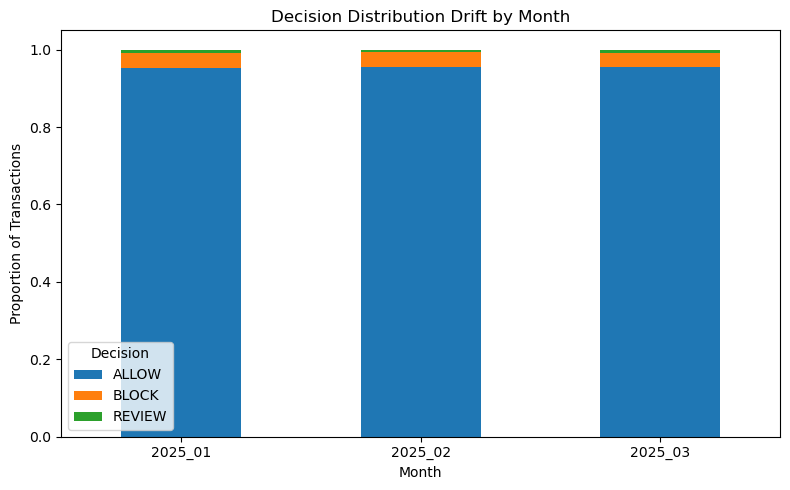

In [4]:
# ============================================================
# M1: DECISION DRIFT VISUALIZATION
# ============================================================

import matplotlib.pyplot as plt

decision_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
)

plt.title("Decision Distribution Drift by Month")
plt.xlabel("Month")
plt.ylabel("Proportion of Transactions")
plt.legend(title="Decision")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


M2: ML Risk Score Drift

This analysis monitors how the ML risk score behaves over time.

We track:

Average ML risk score by decision (ALLOW / REVIEW / BLOCK)

Consistency of score separation

Early signals of model drift

A healthy system shows:

Clear separation between decisions

Stable scores across months

No overlap between ALLOW and BLOCK risk levels

In [5]:
# ============================================================
# M2: ML RISK SCORE DRIFT CALCULATION
# ============================================================

ml_drift = (
    multi_df
    .groupby(["month", "decision"])["ml_risk_score"]
    .mean()
    .reset_index()
)

ml_drift_pivot = ml_drift.pivot(
    index="month",
    columns="decision",
    values="ml_risk_score"
)

ml_drift_pivot


decision,ALLOW,BLOCK,REVIEW
month,,,
2025_01,0.000018,0.994942,0.306422
2025_02,0.000005,0.995170,0.250073
2025_03,0.000005,0.994765,0.273793


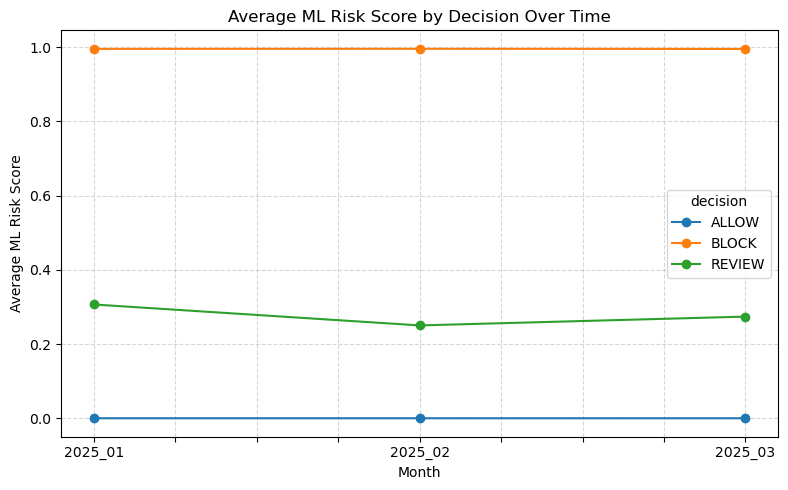

In [6]:
# ============================================================
# M2: ML RISK SCORE DRIFT VISUALIZATION
# ============================================================

ml_drift_pivot.plot(
    kind="line",
    marker="o",
    figsize=(8, 5)
)

plt.title("Average ML Risk Score by Decision Over Time")
plt.xlabel("Month")
plt.ylabel("Average ML Risk Score")
plt.xticks(rotation=0)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


M3: Trust Evolution & Customer Lifecycle Analysis

This phase analyses how customer trust behaves over time and how risk differs between new and existing customers.

Objectives:

Track average trust score by month

Compare risk behaviour of new vs existing customers

Validate trust carry-forward logic from Part A

This mirrors how trust systems are monitored in production.

In [7]:
# ============================================================
# M3: TRUST EVOLUTION OVER TIME
# ============================================================

trust_trend = (
    multi_df
    .groupby("month")["trust_score"]
    .mean()
    .reset_index()
)

trust_trend


,month,trust_score
0,2025_01,55.331539
1,2025_02,55.588413
2,2025_03,56.135516


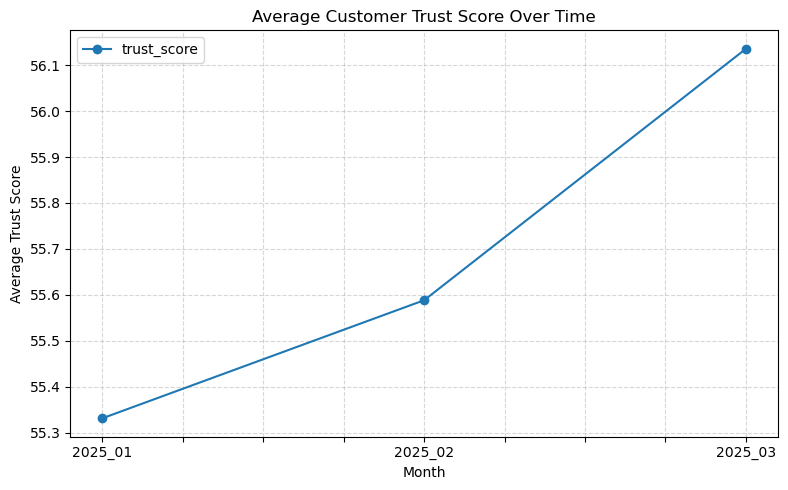

In [8]:
# ============================================================
# M3: TRUST EVOLUTION VISUALIZATION
# ============================================================

trust_trend.plot(
    x="month",
    y="trust_score",
    kind="line",
    marker="o",
    figsize=(8, 5)
)

plt.title("Average Customer Trust Score Over Time")
plt.xlabel("Month")
plt.ylabel("Average Trust Score")
plt.xticks(rotation=0)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
# ============================================================
# M3: NEW VS EXISTING CUSTOMER RISK
# ============================================================

customer_risk = (
    multi_df
    .groupby(["month", "is_new_customer", "decision"])
    .size()
    .reset_index(name="count")
)

customer_risk["total"] = customer_risk.groupby(
    ["month", "is_new_customer"]
)["count"].transform("sum")

customer_risk["proportion"] = customer_risk["count"] / customer_risk["total"]

customer_risk_pivot = customer_risk.pivot_table(
    index=["month", "is_new_customer"],
    columns="decision",
    values="proportion",
    fill_value=0
)

customer_risk_pivot


decision                    ALLOW     BLOCK    REVIEW
month   is_new_customer                              
2025_01 0                0.953706  0.039842  0.006452
        1                0.932529  0.042593  0.024877
2025_02 0                0.955092  0.038618  0.006290
        1                0.945136  0.035240  0.019624
2025_03 0                0.956397  0.037255  0.006348
        1                0.935397  0.038690  0.025913

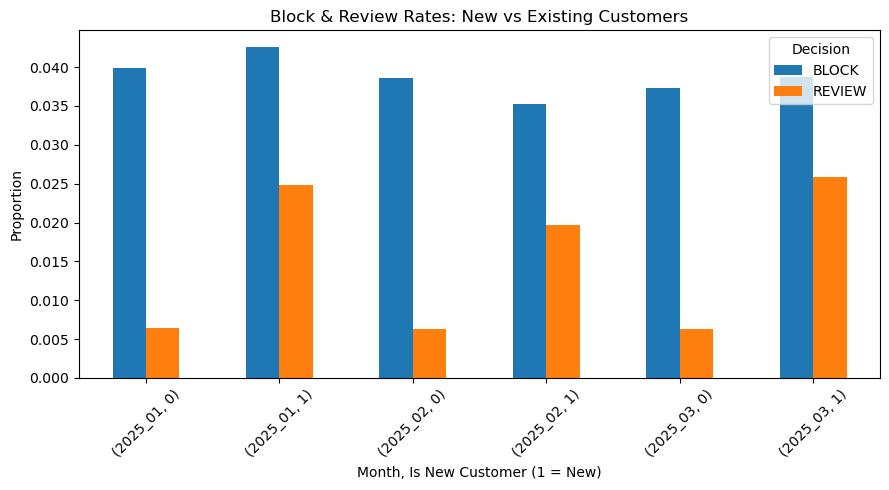

In [10]:
# ============================================================
# M3: NEW VS EXISTING CUSTOMER RISK VISUALIZATION
# ============================================================

customer_risk_pivot[["BLOCK", "REVIEW"]].plot(
    kind="bar",
    figsize=(9, 5)
)

plt.title("Block & Review Rates: New vs Existing Customers")
plt.xlabel("Month, Is New Customer (1 = New)")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Decision")
plt.tight_layout()
plt.show()


M4: Corridor Risk Concentration Analysis

This analysis identifies which source–destination corridors contribute most to BLOCK decisions.

Objectives:

Understand concentration of high-risk traffic

Detect emerging risky corridors

Support policy and controls tuning

This mirrors real cross-border payments risk monitoring.

In [11]:
# ============================================================
# M4: CORRIDOR BLOCK CONCENTRATION
# ============================================================

# Create corridor label
multi_df["corridor"] = (
    multi_df["source_country"] + " → " + multi_df["destination_country"]
)

# Focus only on BLOCK transactions
blocked_df = multi_df[multi_df["decision"] == "BLOCK"]

corridor_blocks = (
    blocked_df
    .groupby(["month", "corridor"])
    .size()
    .reset_index(name="block_count")
)

# Top corridors per month
corridor_blocks_sorted = corridor_blocks.sort_values(
    ["month", "block_count"], ascending=[True, False]
)

corridor_blocks_sorted.head(10)


,month,corridor,block_count
1,2025_01,IN → NG,4019
2,2025_01,IN → SG,60
4,2025_01,IN → US,60
3,2025_01,IN → UK,51
0,2025_01,IN → AE,50
6,2025_02,IN → NG,3896
5,2025_02,IN → AE,58
9,2025_02,IN → US,48
7,2025_02,IN → SG,44
8,2025_02,IN → UK,44


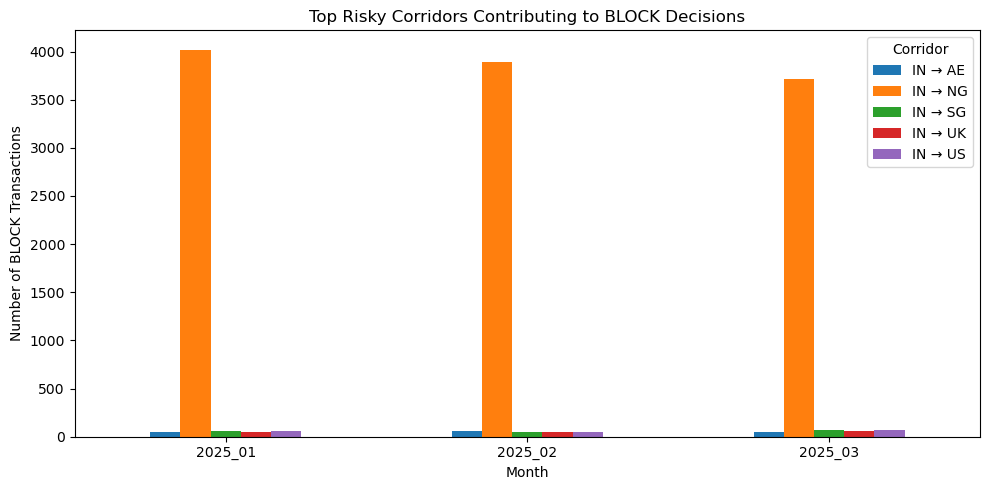

In [12]:
# ============================================================
# M4: CORRIDOR BLOCK VISUALIZATION
# ============================================================

# Identify top 5 corridors across all months
top_corridors = (
    blocked_df["corridor"]
    .value_counts()
    .head(5)
    .index
)

top_corridor_df = corridor_blocks[
    corridor_blocks["corridor"].isin(top_corridors)
]

pivot_corridor = top_corridor_df.pivot(
    index="month",
    columns="corridor",
    values="block_count"
).fillna(0)

pivot_corridor.plot(
    kind="bar",
    figsize=(10, 5)
)

plt.title("Top Risky Corridors Contributing to BLOCK Decisions")
plt.xlabel("Month")
plt.ylabel("Number of BLOCK Transactions")
plt.xticks(rotation=0)
plt.legend(title="Corridor")
plt.tight_layout()
plt.show()
